# Stock price prediction

## Motivation

Rather than having your retirement savings passively grow by following a [lazy portfolio](https://canadiancouchpotato.com/model-portfolios/), would it be possible to actively gain more by predicting stock prices and taking advantage of price swings? With a relatively small capital, one may be able to silently follow large market movers and institutions. This notebook is a simple attempt outperform passive gains by using machine learning. It is not financial advice and should not be treated as such. Do not attempt to trade without seeking professional advice.

## Data sources

Historical stock data, including data on individual trades, is available freely from the [Polygon API](https://polygon.io/docs/getting-started) after signing up for an account at [Alpaca](https://alpaca.markets/docs/api-documentation/). To take full advantage of short-term price swings, stock prices should be predicted at the time scale of seconds. Therefore, data on individual trades will be fetched and analysed rather than aggregate bars summarizing price movements at the scale of minutes to days.

Fetched data is stored in a local [MySQL](https://www.mysql.com/) database for easy access. To replicate the outputs of this notebook, first install and configure the database as described in the README.

## Load requirements

In [1]:
# Load system libraries.
import os
import sys
import shutil
import time
import random
import datetime
import collections
import functools
import textwrap
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import sklearn
import sklearn.ensemble
import sklearn.metrics
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16, 9)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2
import config
import data.data_manager as data
from utils import utils, model_tuning
from features import feature_manager, target, trade_properties, bar_properties, \
    bar_changes, times

## Fetch data on trades

Download all trades from the last years for a stock of interest. The selected stock should have plenty of data (high trade volume) and a unique name to permit future analysis of news releases and mentions on social media. Microsoft (ticker `MSFT`) fulfills both of those requirements.

In [3]:
ticker = 'MSFT'
date_from = '2019-01-01'
date_to = '2020-12-31'

data.download_trades(ticker, date_from, date_to, verbose=True)

01:16:51 All days of trades from 2019-01-01 to 2020-12-31 are already stored.


## Exploratory analysis

In the optimal case, where we know everything about the future, how do we decide when to buy and sell to optimise profits? Several questions need to be answered:

1. During what hours should are trades most likely to be profitable? Regular hours or pre- and post-market?
2. How much does the price have to increase for a buy to be profitable to offset the bid-ask spread? 
3. What time scale is needed to capture all price changes of interest?

### 1. During what hours?

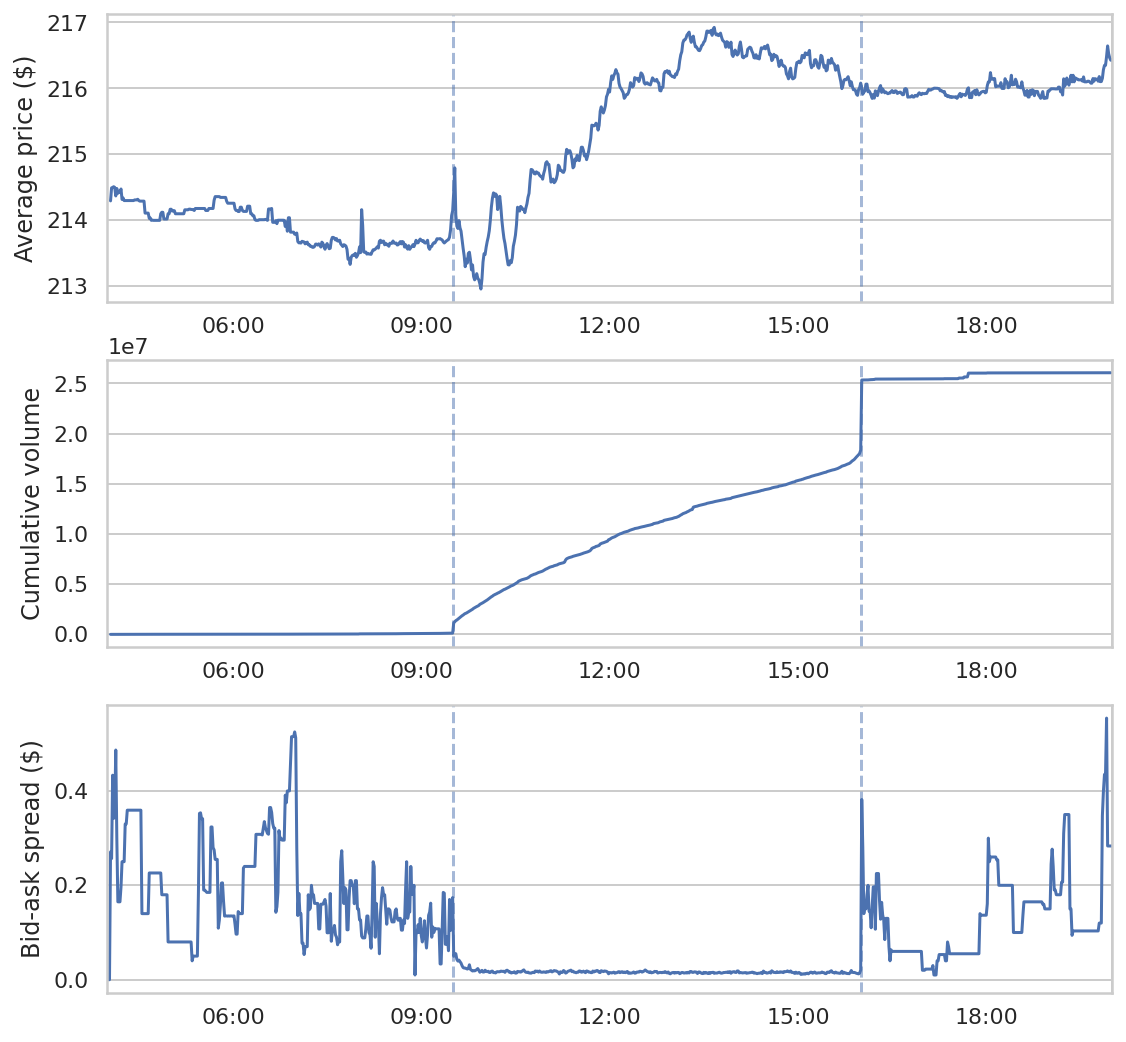

In [44]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# Plot average price of trades.
price_per_minute = data.get_bars(
    ticker, date, 'trades', agg='mean', freq='1min', extended_hours=True
)['price'].fillna(method='ffill')
price_per_minute.plot.line(ax=axes[0], ylabel='Average price ($)')

# Plot comulative volume of trades.
volume_per_minute = data.get_bars(
    ticker, date, 'trades', agg='sum', freq='1min', extended_hours=True
)['volume']
volume_per_minute.cumsum().plot.line(ax=axes[1], ylabel='Cumulative volume')

# Plot bid-ask spread of trades.
bid_ask_spread_per_minute = data.get_bars(
    ticker, date, 'quotes', agg='mean', freq='1min', extended_hours=True
)['spread'].fillna(method='ffill')

bid_ask_spread_per_minute.plot.line(ax=axes[2], ylabel='Bid-ask spread ($)')

# Add indicator for beginning and end of regular trading hours.
for ax in axes:
    for time in [(9, 30), (16, 0)]:
        ax.axvline(
            datetime.datetime.combine(date, datetime.time(*time)), 
            linestyle='--', alpha=0.5
        )

The vast majority of trades happen during regular trading hours from 9:30 AM to 4:00 PM. Therefore, the bid-ask spread, i.e. the loss after buying and immediately selling the stock, is significantly higher outside of regular hours, making it riskier to perform any trades then. In addition, most price shifts happen within regular hours, making it reasonable to focus on this time. 

### 2. When is a buy profitable?

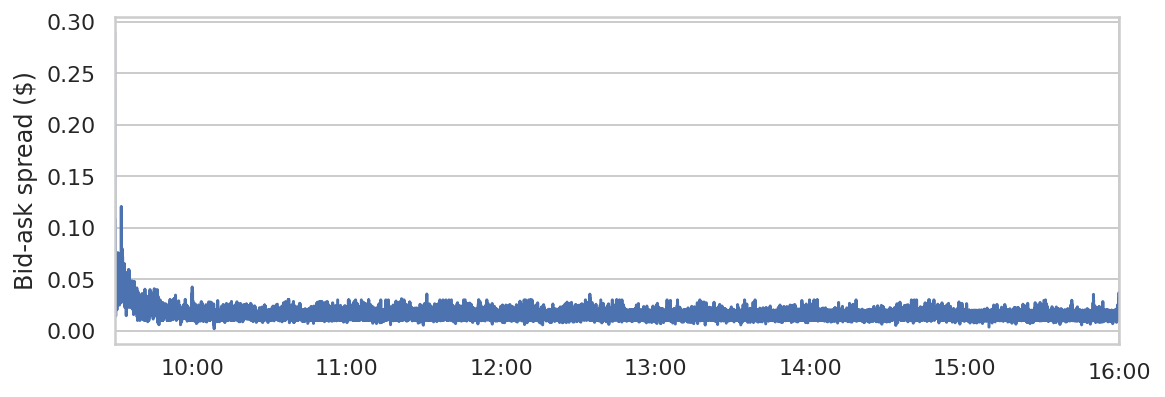

Average bid-ask spread: $0.017


In [53]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)

fig, ax = plt.subplots(figsize=(9, 3))

spread = data.get_bars(ticker, date, 'quotes')['spread']
spread.plot.line(ax=ax, ylabel='Bid-ask spread ($)')
plt.show()

print(f'Average bid-ask spread: ${spread.mean():0.3f}')

The average bid-ask spread is less than \\$0.02, staying below \\$0.05 for most of the day with the exception of the first minutes after opening. Using \\$0.05 as a threshold to consider a trade profitable should be a conservative approach as long as a small number of stocks are bought. For now, that value can be used as a rough threshold, but, optimally, before performing any trade the actual current spread should be checked.

### 3. What time scale?

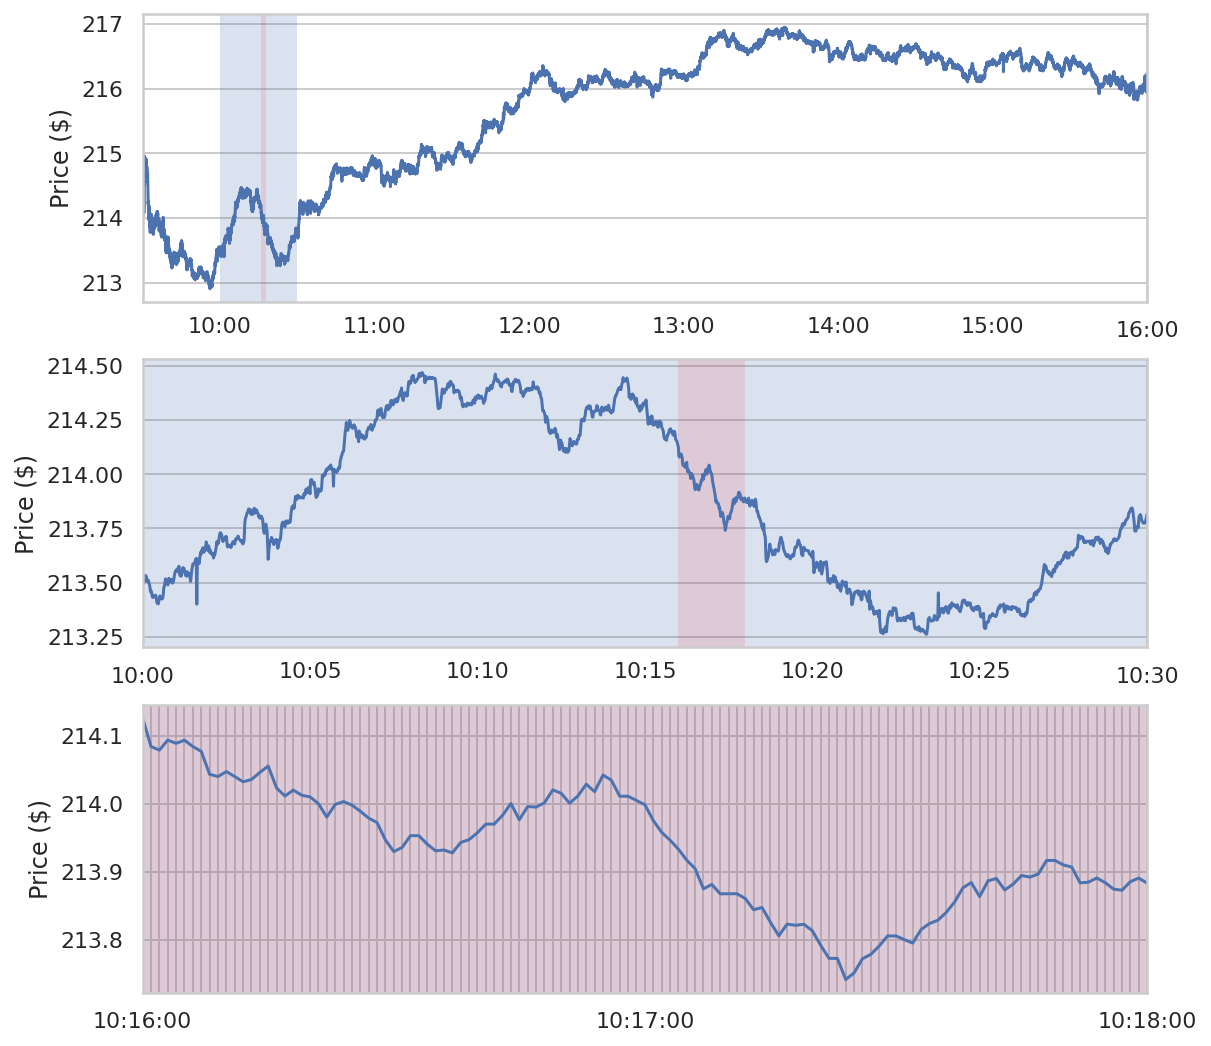

Average trades per second: 9.63


In [62]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# Plot price over the entire day.
price = data.get_bars(ticker, date, freq='1S', fillna=True)['price']
price.plot.line(ax=axes[0], ylabel='Price ($)')

# Plot price over a thirty minute window.
window1 = price.between_time('10:00', '10:30')
window1.plot.line(ax=axes[1], ylabel='Price ($)')

# Plot price over a two minute window.
window2 = price.between_time('10:16', '10:18')
window2.plot.line(ax=axes[2], ylabel='Price ($)')
axes[2].xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1))

# Shade in time windows.
for ax in axes:
    ax.axvspan(*window1.index[[0, -1]], alpha=0.2, lw=0)
    ax.axvspan(*window2.index[[0, -1]], color='red', alpha=0.1, lw=0)

plt.show()
trades_per_second = data.get_bars(ticker, date, agg='count', freq='1S')['price']
print(f'Average trades per second: {trades_per_second.mean():0.2f}')

Prices swings exceeding the set \\$0.05 bid-ask spread threshold happen often at the timescale of seconds. Most of the increases above the threshold happens over more than 10 seconds, making it unnecessary to capture nuances at a smaller interval than every second. 

## Target classification: when to buy and sell

Each timepoint should be classified as `buy` or `sell` based on its price changes. Time periods where the price increases more than \\$0.05 should be labeled as `buy`. Time periods where the price decreases should be labeled as `sell`. Small price fluctuations should not interrupt price runs.

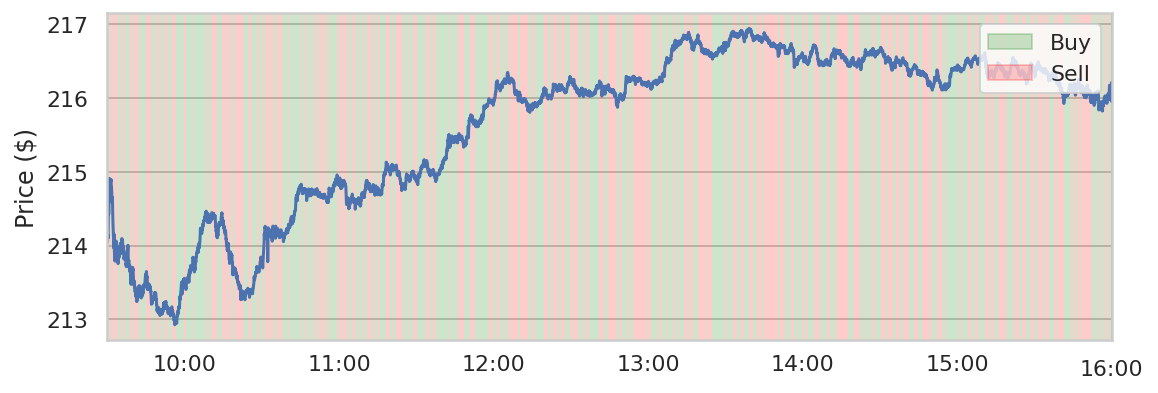

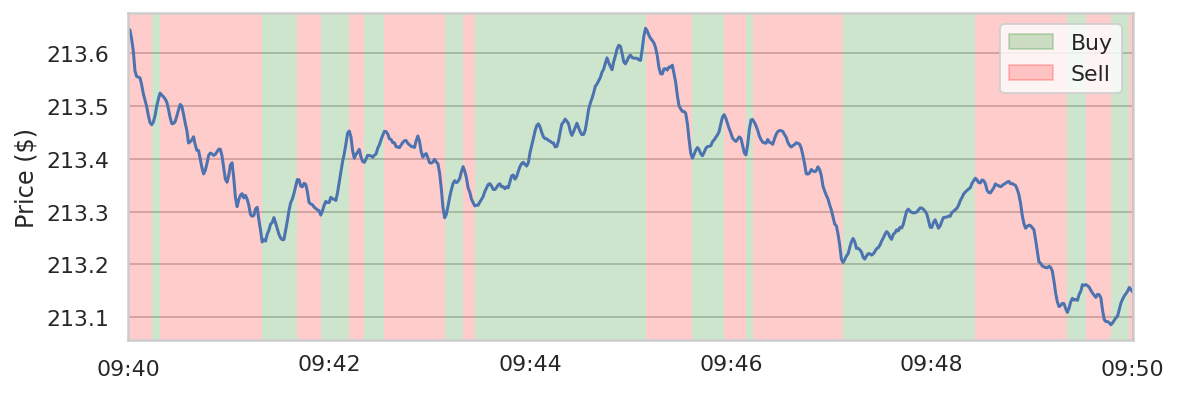

Number of buys: 239
Active gain: 10.82%
Passive gain: 0.83%


In [75]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)

# How many period into the past should the current price be smoothed by to
# reduce low-level noise? More smoothing is less risky.
periods_to_smooth_price = 3

# How much, in dollars, does a stock have to gain while its held for the
# transaction to be profitable. A higher estimate is less risky.
gain_threshold = 0.05

# Get price aggregates per second.
price = data.get_bars(
    ticker, date, agg='weighted_mean', smooth_periods=periods_to_smooth_price, fillna=True
)

# Label long ups as buy, and long downs as sell.
params = {'periods_to_smooth_by': periods_to_smooth_price, 'gain_threshold': gain_threshold}
label = target.label_buy_or_sell(ticker, date, params)
target.plot_timeseries(price, label)
target.plot_timeseries(price.between_time('9:40', '9:50'), label.between_time('9:40', '9:50'))

# Calculate hypothetical gains.
profits = target.profits(price, label, buy_cost=gain_threshold)
print(f'Number of buys: {profits["total_buys"]}')
print(f'Active gain: {profits["active_gain"]*100:.2f}%')
print(f'Passive gain: {profits["passive_gain"]*100:.2f}%')

An all-knowing investor would be able to gain more than 10% over a single day, compared to passive investors, who would gain less than 1%. Those numbers are motivating, but we are unfortunately not all-knowing.

## Feature engineering

Features need to be generated for every second during open hours. Features include descriptive stats of recent trades and different measures describing changes to these stats. Generated features are stored to disk, as they can take a while to generate. Features are generated one day at a time to allow caching the day's trades in the memory.


### Initial features

- **Top recent trades**: Looking at trades that happened recently, what are the top trades in terms of price and volume, and how long ago did the trade happen? 
    
- **Trade stats of the current bar**: Descriptive stats of trades happening now (within the last second). Includes the mean, median, min, max, and standard deviation of price, volume, and price-adjusted volume (price * volume).

- **Current bar compared to rolling average**: The relative changes in the current stats compared to a preceding time window. The time window varies from 3 seconds into the past to the beginning of the day (but currently not any previous days).

- **Current price compared to previous high and low**: The relative change price compared to the high and low of a preceding time window. The time window varies from 1 minute into the past to the beginning of the day (but currently not any previous days).

- **Current price compared to the beginning of larger bars**: The relative change in the price compared to the beginning of the minute, hour, day, and a few frequencies in between.

- **Trade stats of recent bars**: Descriptive stats of trades that happened during recent time periods (compared to now) going back a defined number of seconds.

- **Changes to stats of recent bars**: The change in stats for recent time periods (compared to bar preceding it) going back a defined number of seconds.

- **Proportion of recent bars that increased**: The proportion of times in a preceding time window that saw an increase in price or volume (considered separately). The time window varies from 1 second into the past to the beginning of the day.

- **Number of consequtive bars that increased**: How far into the past the price or volume (considered separately) has been increasing after applying a moving average smoothening. The moving average time window varies from 1 second to 30 minutes.

- **Current time and date**: The second, minute, and hour of the day, as well the day of the week, month, quarter, and year.

- **Time since and until the beginning of a significant period**: The seconds since trading started for the day and until trading closes for the day (may be different on half-days after holidays), as well as the number of business days since the first business day and until the last business day of the month, quarter, and year.

- **Time since holiday**: The number days since the last holiday causing exchanges to be closed when it would have otherwise been open. Also includes whether a day is a half-day where the exchanges closes early due to a holiday (e.g. the day after Thanksgiving).

In [76]:
ticker = 'MSFT'
features = feature_manager.FeatureManager(ticker)

features.add_many([
    (
        'Target',
        target.label_buy_or_sell,
        {'gain_threshold': 0.05},
    ),
    (
        'Top recent trades',
        trade_properties.top_recent_trades,
        {'num_of_trades': 100, 'num_of_top_trades': 10},
    ), 
    (
        'Trade stats of the current bar',
        bar_properties.current_bar_stats,
    ), 
    (
        'Current bar compared to rolling average',
        bar_changes.current_bar_compared_to_rolling,
    ), 
    (
        'Current price compared to previous high and low',
        bar_changes.current_bar_compared_to_high_and_low,
    ), 
    (
        'Current price compared to the beginning of larger bars',
        bar_changes.current_bar_compared_to_open,
    ), 
    (
        'Trade stats of recent bars',
        bar_changes.recent_bars_compared_to_current,
        {'periods_to_go_back': 60},
    ), 
    (
        'Changes to stats of recent bars',
        bar_changes.recent_bars_compared_to_preceding,
        {'periods_to_go_back': 60},
    ), 
    (
        'Proportion of recent bars that increased',
        bar_changes.proportion_of_increasing_bars,
    ), 
    (
        'Number of consequtive bars that increased',
        bar_changes.consecutive_of_increasing_bars,
    ), 
    (
        'Current time and date',
        times.current_time_and_date,
    ), 
    (
        'Time since and until the beginning of a significant period',
        times.time_since_and_until_start_of,
    ), 
    (
        'Time since holiday',
        times.time_since_holiday,
    )
])

features.generate('2019-11-01', '2020-12-31')

13:49:15 Feature generation started.
100%|██████████| 294/294 [00:00<00:00, 406837.80it/s]
13:49:15 Feature generation completed.


### Addition feature ideas

- Technical indicators.
- Comparing prices/volumes across different days.
- Stats on bid-ask spread.
- Relevant news articles.
- Mentions on social networks.

## Hyperparameter tuning

The best hyperparameters are searched for by first using a random approach to broadly sample hyperparameter space. If the search results in a significant bump in performance, a more thorough grid search is then performed.

### Initial randomized parameter search
The data is sampled to one month of trades for training the model, ensuring everything can fit in memory. To decrease bias towards the sample, three models are trained on three different time periods for each parameter set. Each model is tested on the business day following the training period.

First, setup the time periods to use, the base model to optimize, the parameter grid to sample hyperparameters from, and the metrics to evaluate the model with.

In [2]:
ticker = 'MSFT'
number_of_iterations = 100
random_search_save_path = 'models/random_search'

# Dates for time periods to use as samples.
sample_dates = [
    {'train': ('2020-03-01', '2020-03-31'), 'test': ('2020-04-01',)},
    {'train': ('2020-09-09', '2020-10-08'), 'test': ('2020-10-09',)},
    {'train': ('2020-11-28', '2020-12-27'), 'test': ('2020-12-28',)},
]

# Base model to optimize.
def base_model(**params):
    return sklearn.ensemble.RandomForestClassifier(
        n_jobs=15, random_state=1, criterion='gini', max_features='sqrt', 
        bootstrap=True, **params
    )

# Parameter grid to sample hyperparameters from.
param_grid = {
    'max_depth': [3, 10, 30, 100, None],
    'min_samples_leaf': [3, 10, 30, 100, 300, 1000],
    'min_samples_split': [10, 30, 100, 300, 1000, 3000, 10000],
    'max_samples': [0.01, 0.03, 0.1, 0.3, None],
    'n_estimators': [30, 100, 300],
}

# Metrics to score the models by.
metrics_to_score = [
    ('accuracy', sklearn.metrics.accuracy_score),
    ('precision', sklearn.metrics.precision_score),
    ('recall', sklearn.metrics.recall_score),
    ('profits', functools.partial(target.profits_metric, ticker=ticker)),
]

Then run the parameter search.

In [16]:
# Randomize parameters.
random_params = utils.sample_dict(param_grid, number_of_iterations-1, random_seed=0)
random_params.insert(0, {})  # first model is base model

# Fit and score a model for each parameter.
search_results = []
for sample_i, dates in enumerate(sample_dates): 
    print(f'Sample {sample_i + 1}')
    # Fit.
    save_path = os.path.join(random_search_save_path, f'sample{sample_i}')
    get_Xy_train = lambda _: data.get_features(ticker, *sample_dates[sample_i]['train'])
    model_tuning.fit_multiple_parameters(
        base_model, get_Xy_train, random_params, save_path
    )
    # Score.
    get_Xy_train = lambda _: data.get_features(ticker, *sample_dates[sample_i]['test'])
    search_result = model_tuning.score_models(
        save_path, get_Xy_train, get_Xy_test, random_params, metrics_to_score, 
    )
    search_result.columns = pd.MultiIndex.from_product([search_result.columns, [sample_i]])
    search_results.append(search_result)
search_results = pd.concat(search_results, axis=1, copy=False, sort=False)

Sample 1
Scoring: 100%|██████████| 100/100 [11:42<00:00,  7.02s/it]
Sample 2
Scoring: 100%|██████████| 100/100 [11:30<00:00,  6.90s/it]
Sample 3
Scoring: 100%|██████████| 100/100 [09:28<00:00,  5.69s/it]


### Analysis of initial randomized parameter search

With 100 models run, it becomes possible to answer several questions:

- Do any hyperparameter sets improve the base model?
- Are any of the models profitable?

#### Improvements over the base model?

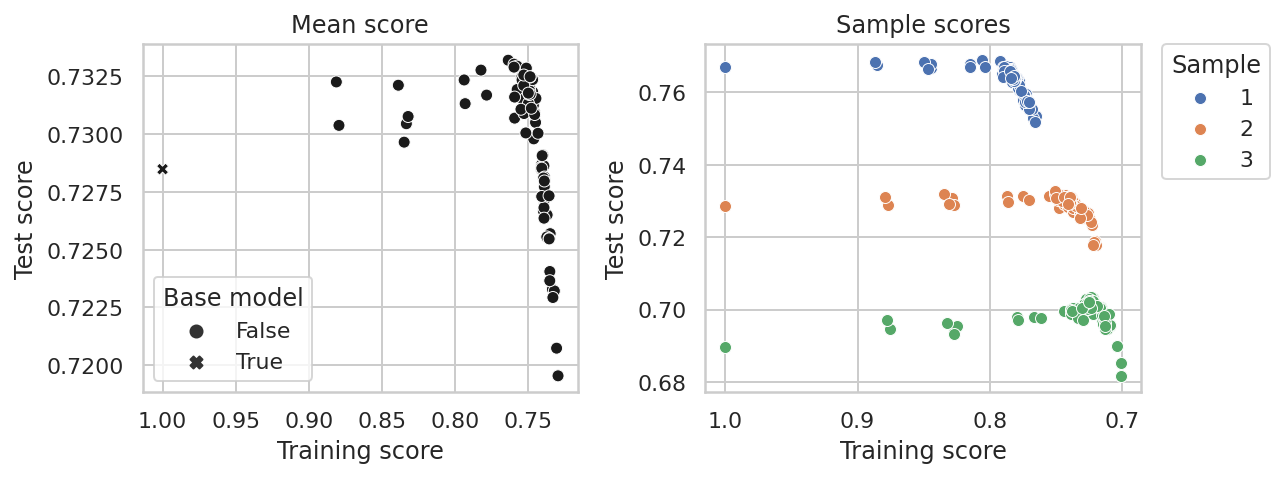

In [37]:
# Exclude outliers from plots.
filtered_results = search_results[
    search_results['train_accuracy'].mean(axis=1) > 0.6
]

# Plot mean training and test scores.
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
sns.scatterplot(
    ax=axes[0], 
    x=filtered_results['train_accuracy'].mean(axis=1), 
    y=filtered_results['test_accuracy'].mean(axis=1), 
    style=(filtered_results.index < 1),  # style base model differently
    color='k', 
)
axes[0].set_title('Mean score')
axes[0].legend(title='Base model', loc=3)

# Plot training and test scores for each sample.
for sample_i in range(len(sample_dates)):
    sns.scatterplot(
        ax=axes[1], 
        x=filtered_results[('train_accuracy', sample_i)],
        y=filtered_results[('test_accuracy', sample_i)],
        label=f'{sample_i+1}',
    )
axes[1].set_title('Sample scores')
axes[1].legend(title='Sample', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
# Add labels to axes.
for ax in axes:
    ax.invert_xaxis()
    ax.set_ylabel('Test score')
    ax.set_xlabel('Training score')
fig.tight_layout()
plt.show()

The base model is highly overfit, achieving a perfect training score. Reducing model complexity results in a slightly better test score, which increases from `0.728` to `0.733`. Surprisingly, a large variation is seen across samples of different time periods. To futher optimize the model, it could be worth looking into why some days give better results than others. 

#### Are any of the models profitable?

In [80]:
# Get best results in terms of accuracy and profits.
for name, measure in [('Most profitable', 'test_profits'), ('Highest accuracy', 'test_accuracy')]:
    model_idx = search_results[measure].mean(axis=1).sort_values().index[-1]
    model = search_results.loc[model_idx]
    print(textwrap.dedent(f'''
        :: {name} model (#{model_idx}) ::'
        Train score: {model["train_accuracy"].mean():0.3f}
        Test score: {model["test_accuracy"].mean():0.3f}
        Precision: {model["test_precision"].mean():0.3f}
        Recall: {model["test_recall"].mean():0.3f}
        Hypothetical profits: {", ".join([f"{p*100:0.1f}%" for p in model["test_profits"]])}
        Parameters: {random_params[model_idx]}
    '''))


:: Most profitable model (#29) ::'
Train score: 0.525
Test score: 0.562
Precision: 0.562
Recall: 1.000
Hypothetical profits: -0.0%, -0.0%, -0.0%
Parameters: {'max_depth': 3, 'max_samples': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 10000, 'n_estimators': 300}


:: Highest accuracy model (#2) ::'
Train score: 0.764
Test score: 0.733
Precision: 0.764
Recall: 0.760
Hypothetical profits: -2.8%, -20.2%, -17.1%
Parameters: {'max_depth': 100, 'max_samples': 0.3, 'min_samples_leaf': 30, 'min_samples_split': 300, 'n_estimators': 100}



The model resulting in the highest profit simply classifies all time points as 'buy', resulting in the profit being identical to a passive growth. 

The model with the highest accuracy score would result in money lost for all three sampled time periods. At best, 3% would be lost, and at worst 20% would be lost in a single day. Significant further improvements are needed for the model to be of any pratical use.

## Further improvements

What could be done to make the model profitable? The most prominent steps forward include:

1. **Adding more features**. Ideas could come from examining the buy/sell classification of the current best model to determine the major factor resulting in loss. If more time periods are sampled, perhaps some would be profitable. Comparing the days with best and worst performances could resolve patterns leading to new features. Other features could include technical indicators, examining price changes over longer time periods, and news and social media mentions.
2. **Using more data**. At the moment, only one month of data can be loaded into the memory. This could be increased by reducing the number of features, either by trimming unimportant/correlated features or by [dimension reduction](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Alternatively, the model can be [trained incrementally](https://stackoverflow.com/questions/30742727/break-up-random-forest-classification-fit-into-pieces-in-python/54304403), trained in a high-memory environment, or be trained directly from the disk.
3. **Tweaking the model further**. either by performing a more thorough hyperparameter search or using another type of classifier entirely (e.g. gradient boosted tree).

### 1. Ideas for new features

A better understanding of what affects model performance could lead to new feature ideas. To get a better understanding of why the model performs terrible on some days and better on other day, the model will be applied across an entire calendar year. Then, the best and worst days can be compared.

In [92]:
# Best parameters determined by randomized search.
ticker = 'MSFT'
calendar_run_save_path = 'models/calendar_run'
params = {
    'max_depth': 100,
    'min_samples_leaf': 30,
    'min_samples_split': 300,
    'max_samples': 0.3,
    'n_estimators': 100,
}

# Dates for time periods to use as samples.
test_dates = data.get_open_dates(ticker, '2020-01-01', '2020-12-31')
train_dates = [
    (date - datetime.timedelta(days=31),  date - datetime.timedelta(days=1))
    for date in test_dates
]

# Fit models.
model = sklearn.ensemble.RandomForestClassifier(
    n_jobs=15, random_state=1, criterion='gini', max_features='sqrt', 
    bootstrap=True, **params
)
get_Xy_train = lambda i: data.get_features(ticker, *train_dates[i])
model_tuning.fit_multiple_Xy(model, get_Xy_train, train_dates, calendar_run_save_path)

# Score models.
metrics_to_score = [
    ('accuracy', sklearn.metrics.accuracy_score),
    ('profits', functools.partial(target.profits_metric, ticker=ticker)),
    ('total_buys', lambda y, _: ((y == 1) & (y.shift() != 1)).sum()),
]
get_Xy_test = lambda i: data.get_features(ticker, test_dates[i])
calendar_run_results = model_tuning.score_models(
    calendar_run_save_path, '', get_Xy_test, metrics_to_score, changing_Xy=True
)
calendar_run_results.index = pd.to_datetime(test_dates)

Scoring: 100%|██████████| 253/253 [06:35<00:00,  1.56s/it]


Number of days outperforming passive growth: 30 (mean: 35%, max: 134%)
Number of days underperforming passive growth: 223 (mean: -16%, max: -26%)
Accuracy score by date:


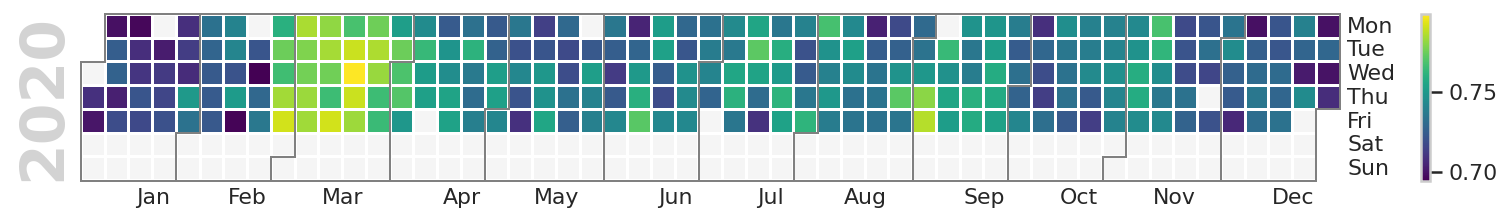

In [133]:
profits = calendar_run_results['test_profits']
for performing, idx in [('outperforming', profits > 0), ('underperforming', profits < 0)]:
    print(
        f'Number of days {performing} passive growth: {idx.sum()} '
        f'(mean: {profits[idx].mean() * 100:0.0f}%, '
        f'max: {max(profits[idx], key=lambda x: abs(x)) * 100:0.0f}%)'
    )
print('Accuracy score by date:')
calplot.calplot(calendar_run_results['test_accuracy']);

For 30 days of the year 2020, the model outperformed passive growth, on average gaining 35% each day. If the model was used to trade on only those days, the initial contribution could have increased more than 100,000% (!). What makes these days profitable? Even if the model cannot be improved further, one potentially successful strategy would be determine indicators for profitable days, and then only trade on such days. 

The calendar plot indicates that model performance is far from random, with good performing days being clustered together. Such patterns suggest that indicators of profitability indeed exist. Some indicators may be found by comparing the best and worst performing days.


:: Best day (2020-03-18) :: 
Passive gain: 4.08% 
Possible active gain: 413.84% (994 buys) 
Predicted active gain: 138.03% (2469 buys) 

Optimal:


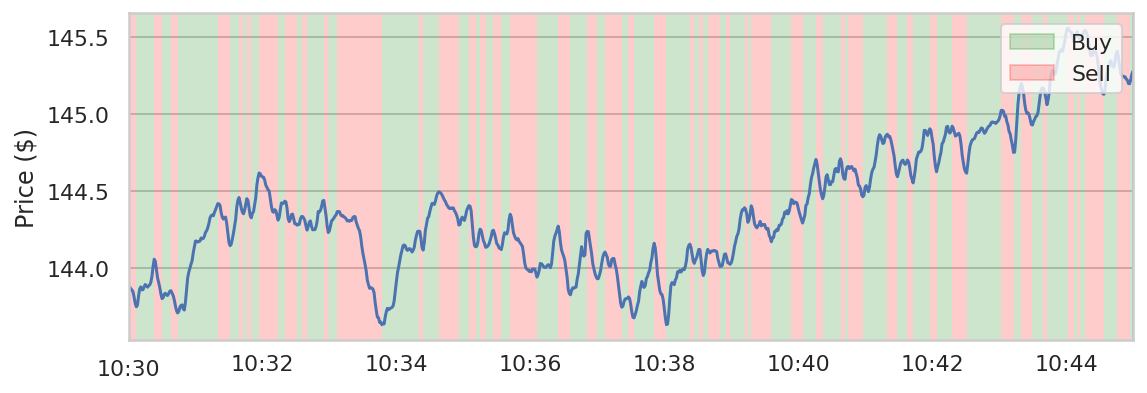

Predicted:


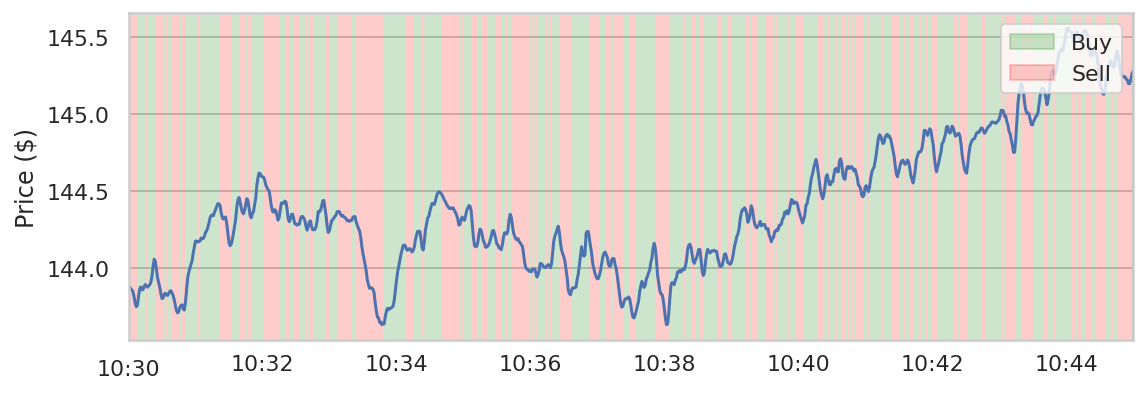


:: Worst day (2020-04-13) :: 
Passive gain: 0.64% 
Possible active gain: 25.26% (354 buys) 
Predicted active gain: -25.48% (2029 buys) 

Optimal:


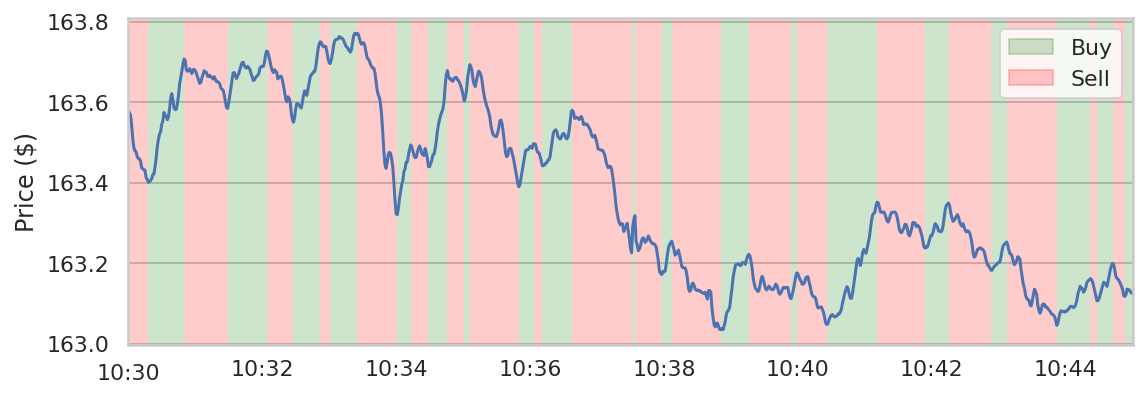

Predicted:


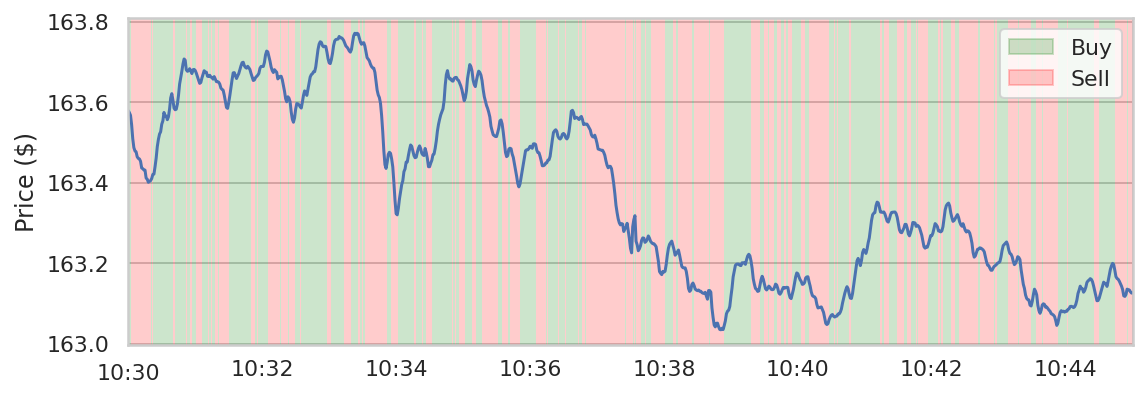

In [151]:
best_idx = profits.argmax()
worst_idx = profits.argmin()

for label, idx in [('best', best_idx), ('worst', worst_idx)]:
    model = joblib.load(os.path.join(
        calendar_run_save_path, f'{idx}_{utils.serialize(train_dates[idx])}.pkl'
    ))
    prices = data.get_prices(ticker, test_dates[idx])
    X, y = get_Xy_test(idx)
    y_pred = pd.Series(model.predict(X), index=y.index)

    profits_actual = target.profits(prices, y, buy_cost=0.05)
    profits_prediction = target.profits(prices, y_pred, buy_cost=0.05)
    print(
        f'\n:: {label.capitalize()} day ({test_dates[idx]}) :: \n'
        f'Passive gain: {profits_actual["passive_gain"]*100:.2f}% \n'
        f'Possible active gain: {profits_actual["active_gain"]*100:.2f}% '
        f'({profits_actual["total_buys"]} buys) \n'
        f'Predicted active gain: {profits_prediction["active_gain"]*100:.2f}% '
        f'({profits_prediction["total_buys"]} buys) \n'
    )
    print('Optimal:')
    target.plot_timeseries(prices.between_time('10:30', '10:45'), y.between_time('10:30', '10:45'))
    print('Predicted:')
    target.plot_timeseries(prices.between_time('10:30', '10:45'), y_pred.between_time('10:30', '10:45'))
    
del model, X, y

Overall, the predictions look familiar to the optimal buy/sell clasifications. Price increases are typically labeled as 'buy' while decreases are labeled as 'sell'. The major issue seems to be that larger runs (series of consecutive price increases or decreases) are frequently interrupted, significantly increasing the total buys, which increases the overall transaction cost. This is most evident for the worst-performing date, which has longer runs that the best-performing date. Is this a trend that is evident across the entire year?

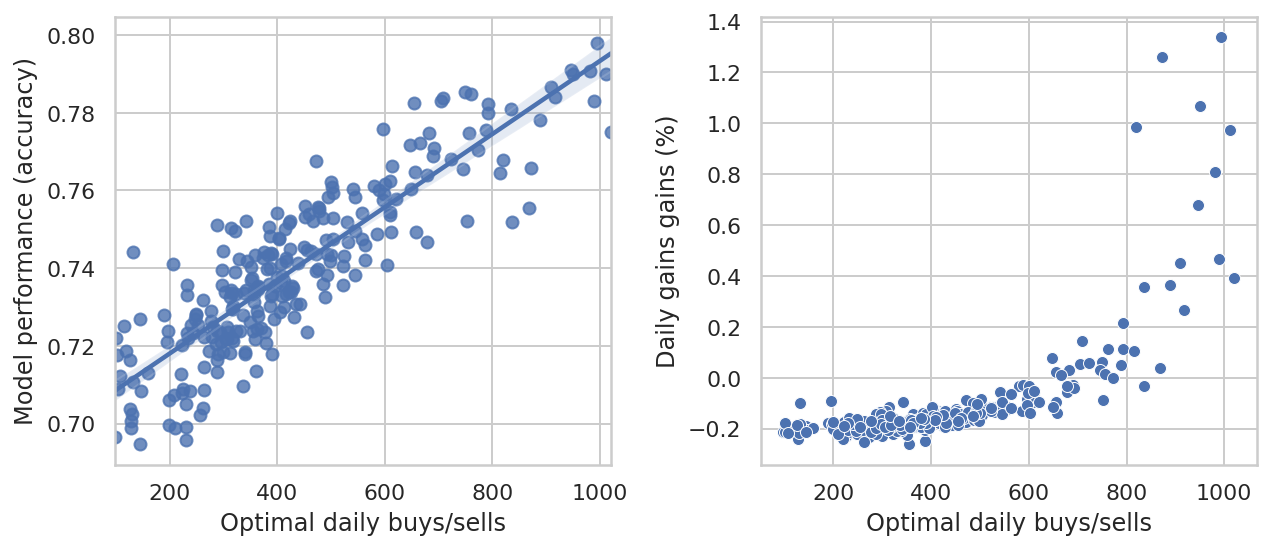

Performance correlation: 0.865 (p = 0.000)
Profitability correlation: 0.819 (p = 0.000)


In [185]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.regplot(x='test_total_buys', y='test_accuracy', data=calendar_run_results, ax=ax[0])
ax[0].set_xlabel('Optimal daily buys/sells')
ax[0].set_ylabel('Model performance (accuracy)')
sns.scatterplot(x='test_total_buys', y='test_profits', data=calendar_run_results, ax=ax[1])
ax[1].set_xlabel('Optimal daily buys/sells')
ax[1].set_ylabel('Daily gains gains (%)')
fig.tight_layout()
plt.show()
results = calendar_run_results
spearman = sc.stats.spearmanr(results['test_total_buys'], results['test_accuracy'])
print(f'Performance correlation: {spearman.correlation:0.3f} (p = {spearman.pvalue:.3f})')
spearman = sc.stats.spearmanr(results['test_total_buys'], results['test_profits'])
print(f'Profitability correlation: {spearman.correlation:0.3f} (p = {spearman.pvalue:.3f})')

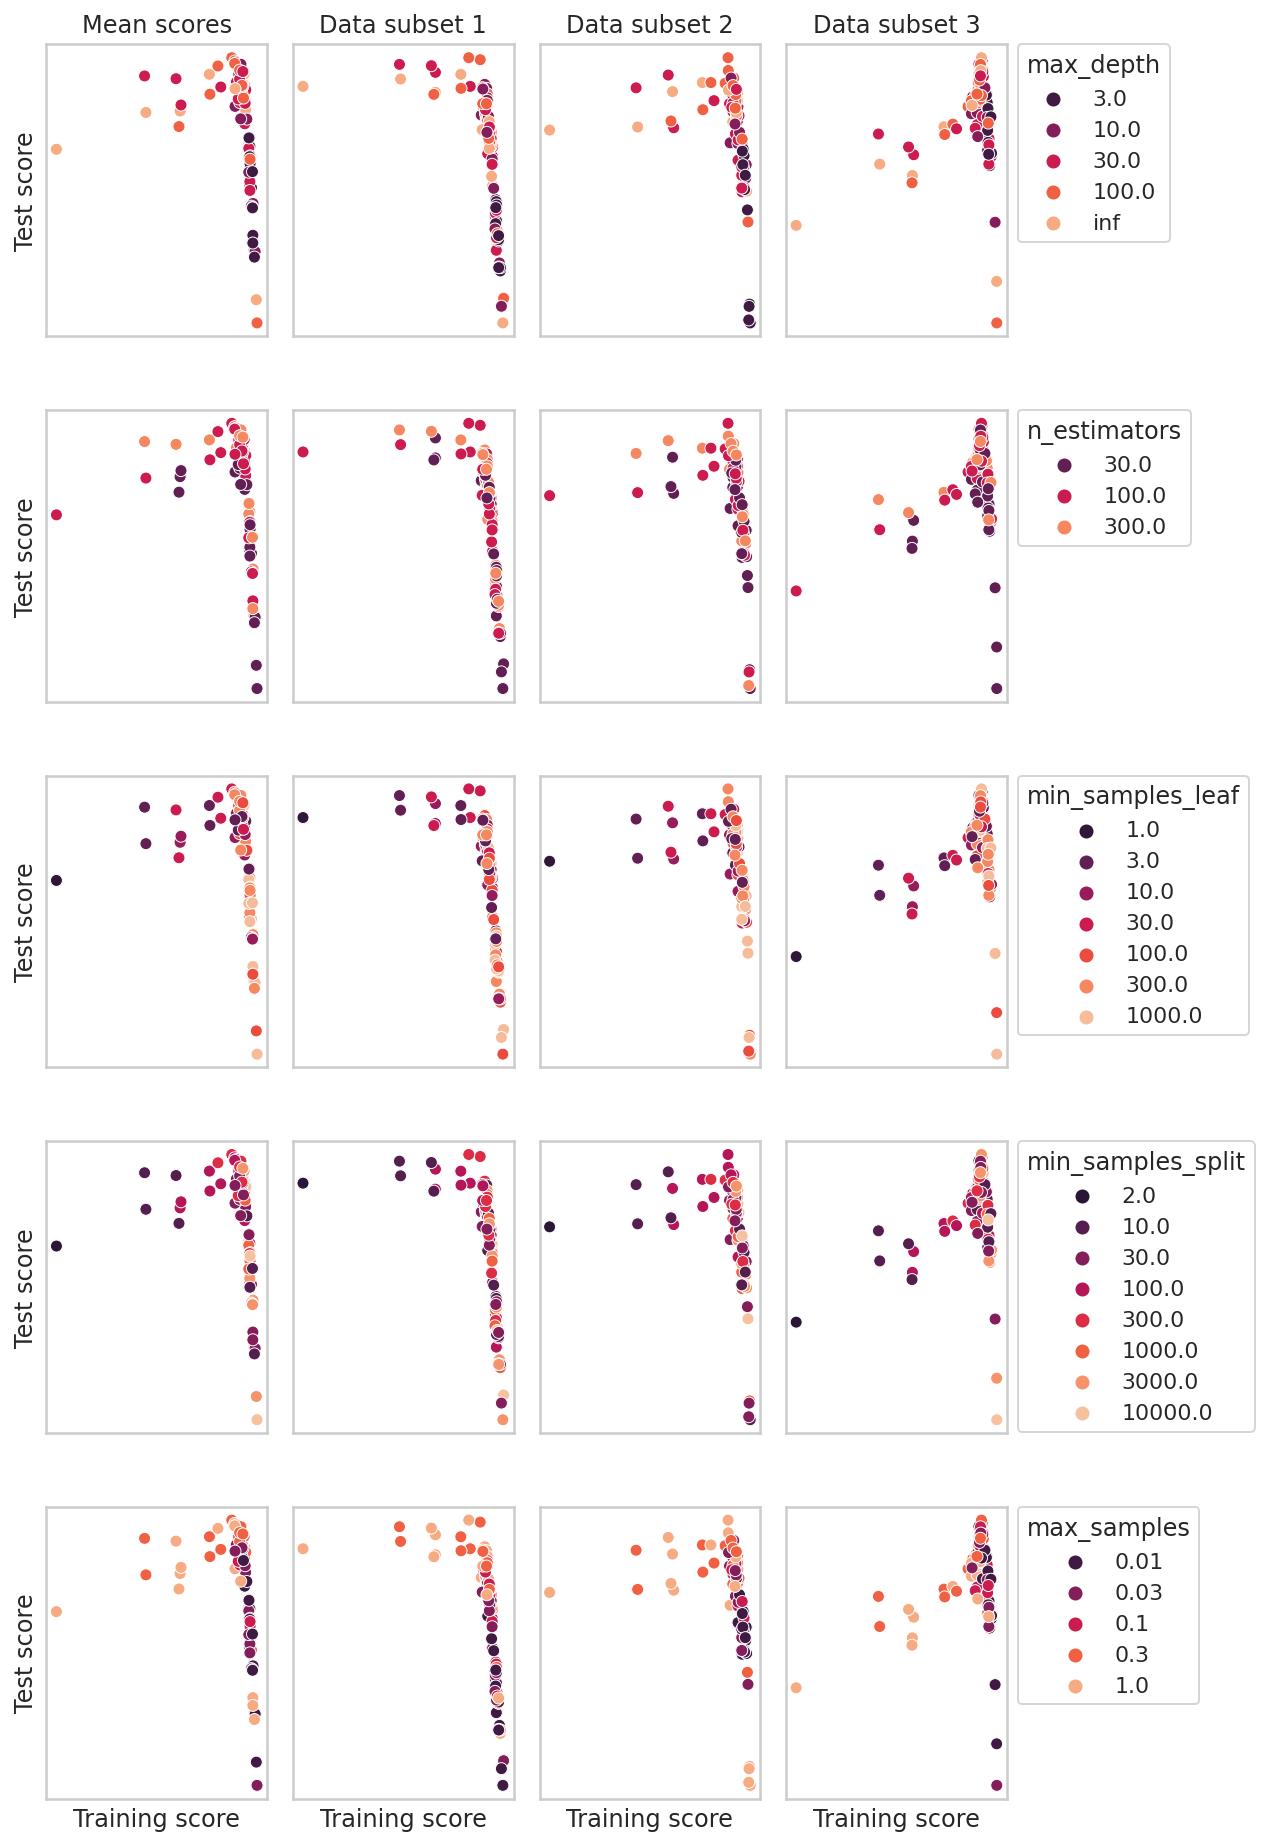

In [23]:
fig, axes = plt.subplots(5, 4, figsize=(9, 13))
axes = axes.flatten()
parameters = ['max_depth', 'n_estimators', 'min_samples_leaf', 'min_samples_split', 'max_samples']

# Set detault parameters for visualization.
search_results_df['max_depth'] = search_results_df['max_depth'].fillna(np.inf)
search_results_df.loc[0, 'n_estimators'] = 100
search_results_df.loc[0, 'min_samples_leaf'] = 1
search_results_df.loc[0, 'min_samples_split'] = 2
search_results_df['max_samples'] = search_results_df['max_samples'].fillna(1)

i = 0
sns.color_palette("rocket", as_cmap=True)
for parameter in parameters:
    hue = search_results_df[parameter].astype(str)
    to_plot = ['mean_train_score', 'train_0', 'train_1', 'train_2']
    for x in to_plot:
        y = x.replace('train', 'test')
        sns.scatterplot(
            ax=axes[i], data=search_results_df, x=x, y=y,
            hue=hue, 
            hue_order=sorted(hue.unique(), key=lambda x: float(x if x != 'nan' else -1)),
            legend=('auto' if x == 'train_2' else False), palette='rocket'
        )
        i += 1

for i, ax in enumerate(axes):
    ax.invert_xaxis()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('Test score' if i % 4 == 0 else '')
    ax.set_xlabel('Training score' if i > 15 else '')
    if i % 4 == 3:
        ax.legend(title=parameters[i // 4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    if i == 0:
        ax.set_title(f'Mean scores')
    if 0 < i < 4:
        ax.set_title(f'Data subset {i}')

fig.tight_layout()

From the third cross-validation, the best-performing parameters are `maxdepth = 50`, `min_samples_leaf = 5`, and `min_samples_split = 100`. The second round of randomized parameter search will center on these values.

### Determining calendar trends in model prediction performance

## Feature pruning

In [10]:
ticker = 'MSFT'

feature_names = list(zip(*sorted(data.db.feature_ids_to_names(ticker).items())))[1][1:]
feature_importance = pd.DataFrame(index=feature_names)

for date in tqdm(dates_with_trades):

    model = joblib.load(f'models/calendar_test/{date}.pkl')
    feature_importance[i] = model.feature_importances_

feature_importance['mean'] = feature_importance.mean(axis=1)

100%|██████████| 253/253 [00:34<00:00,  7.32it/s]


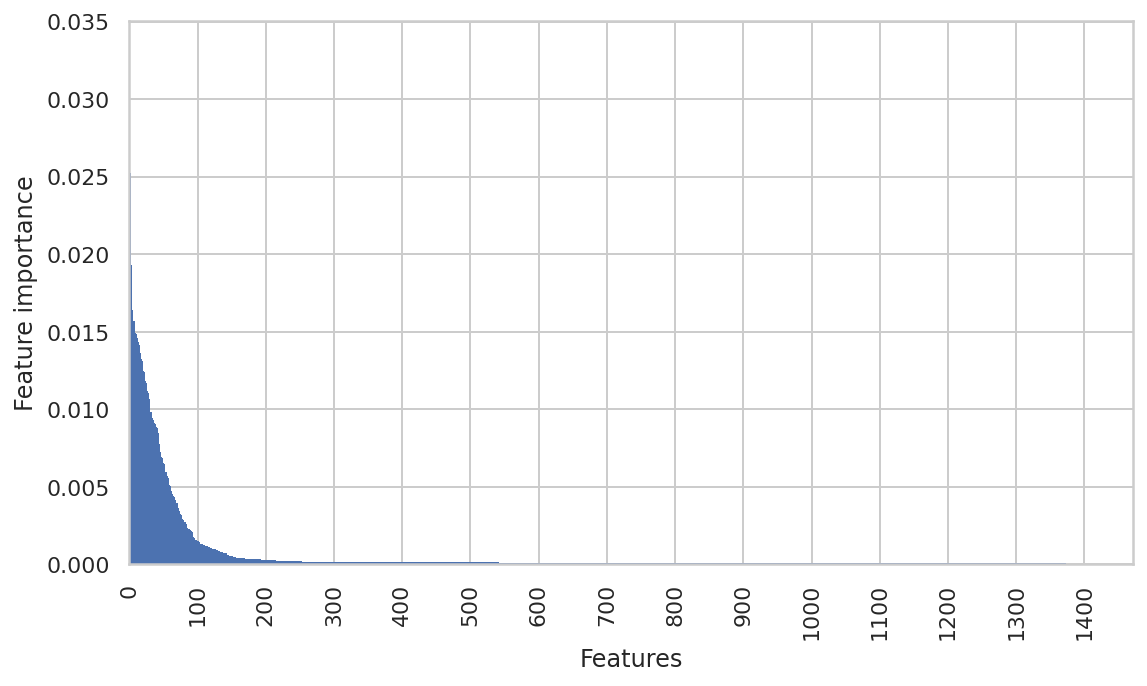

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))
ax = feature_importance.sort_values('mean', ascending=False)['mean'].plot.bar(ax=ax, width=1, lw=0)
ax.set_xticks(range(0, feature_importance.shape[0], 100))
ax.set_xticklabels(range(0, feature_importance.shape[0], 100))
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance')
plt.show()

Ideas:

- Add feature that describes how many local minima and maxima there has been recently, and the price steps between them.
- Prune weak features
- PCA



Previous days, as performance is clustered
Only trade on days with many ups and downs